# Error analysis - height
The purpose of this notebook is to analyse and visualise the erroneous height data in the sample using lazy dask routines. The notebook contains the following sections:
* Missing number analysis for whole sample
* Height data quality aggregated by country
* Height data quality aggregated by region

### Results
* Around 75% of samples have an entry for height
* A cut-off of height < 2.5 m is recommended for identifying uninhabitable structures, based on European buidling requirements
* German, France, Belgium, Netherlands and Italy are in the top 10 countries for buildings with uninhabitable height, by absolute numbers and by proportion.

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgp
import dask
import numpy as np

### Set up

In [5]:
parquet_dir = "./data/parquet/"

### Admininstrative areas
admin = pd.read_csv('./data/admin-codes-matches-v0.1.csv', dtype='str')
admin.drop('source', axis=1, inplace=True)

# Plot style, thanks to https://github.com/dhaitz
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Alternative
# plt.style.use('seaborn-v0_8-pastel')

### How many missing values in the sample?

In [6]:

df = dgp.read_parquet(parquet_dir, index=False)
df_non_null = df.count()
result = df_non_null.compute()

In [7]:
result

id          19840586
height      14807998
age          4891582
geometry    19840586
dtype: int64

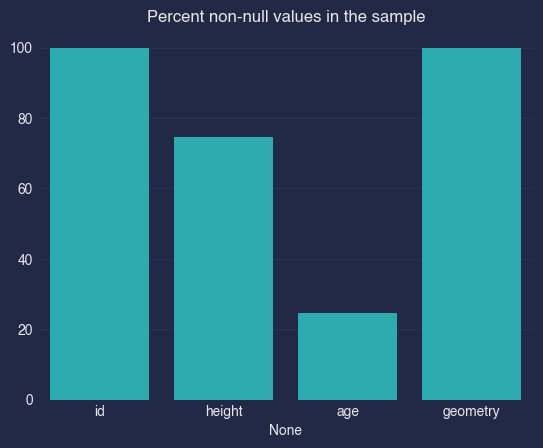

In [8]:
fig = sns.barplot(x=result.index, y=(result.values / result.id)*100);
fig.set_title("Percent non-null values in the sample");

**Figure results**: Every record of 20 Million sample has a geometry and id, but less than 80% have a height entry and 
less than 30% have an age entry.

### Where are missing and potential problematic heights?
Count different categories of height and group by country using Administrative areas (joining on the id_prefix).

Houses less than 2.5 metres in total height are not considerable habitable. This is because France, with the least stringent requirements for ceiling height, requires 2.2 metres for habitable space*, and I have allowed an additional 0.3m for the space from ceiling to roof.

**I suggest a lower cutoff of 2.5m for all structures**

*https://www.researchgate.net/publication/350969899_Housing_Spaces_in_Nine_European_Countries_A_Comparison_of_Dimensional_Requirements

In [9]:
admin.head()

,id,country,region,city
0,v0.1-AUT.4.16.24_1,austria,Oberösterreich,Pilsbach
1,v0.1-AUT.3.15.42_1,austria,Niederösterreich,Wimpassing im Schwarzatale
2,v0.1-AUT.3.15.43_1,austria,Niederösterreich,Würflach
3,v0.1-AUT.3.15.44_1,austria,Niederösterreich,Zöbern
4,v0.1-AUT.3.17.1_1,austria,Niederösterreich,Sankt Pölten


### Height categories by country: dask lazy calculation

In [10]:
def height_cat(x):
    if (x is pd.NA) or (x <= 0):
        return "invalid"
    elif x < 2.5:
        # Not habitable under 2.5 m
        return "less 2.5 m"
    elif x > 310:
        # Largest building in EU is in Poland at 310m
        return "greater 310 m"
    else:
        return "valid"
    
### Find how many records have height and age

df = dd.read_parquet("./data/parquet/", index=False, columns=["id", "height"])
df = df.astype(dtype={"id": pd.StringDtype(), "height": pd.Float32Dtype()})  
df['id_prefix'] = df.id.apply(lambda x: x.rsplit('-', maxsplit=1)[0], meta= pd.Series(dtype=pd.StringDtype()))
df_a = dd.merge(left=df[["id_prefix", "height"]], right=admin[["country","id"]], 
                     left_on="id_prefix", right_on = "id", how="left")

df_a = df_a.drop(columns=["id_prefix", "id"])

df_a["cat_height"] = df_a.height.map(height_cat, meta=pd.Series(dtype=pd.StringDtype()))

df_sum = df_a.groupby(["country", "cat_height"], sort=True).cat_height.count()
df_sum_country  = df_sum.groupby(["country"]).sum()
df_percent = df_sum / df_sum_country * 100
df_percent = df_percent.rename("percent")
df_sum = df_sum.rename("sum")

In [11]:
dfc_sum, dfc_percent = dask.compute(df_sum, df_percent)

In [12]:

## Sanity check
check = dfc_percent.groupby("country").sum()
if np.isclose(check,100).all():
    print("All percents add to 100 for each country")
else:
    print("Failure to add to 100 percent for following countries")
    print(check[~np.isclose(check,100)])

All percents add to 100 for each country


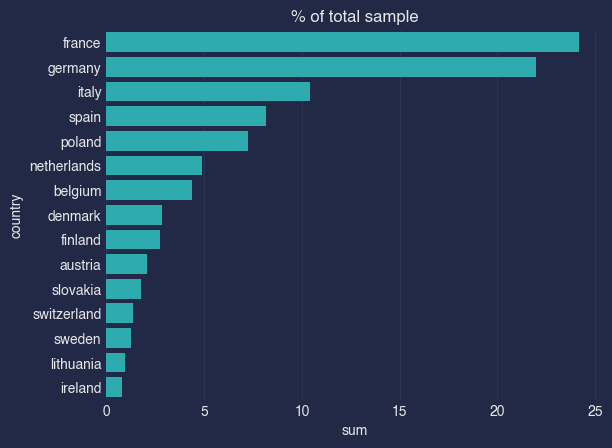

In [13]:
country_sums = dfc_sum.groupby("country").sum()
country_percent = country_sums / country_sums.sum() * 100
plot_df = country_percent.reset_index()
orderby = plot_df.sort_values("sum", ascending=False)
sns.barplot(plot_df, y="country", x="sum", order=orderby["country"][:15]);
plt.title("% of total sample");

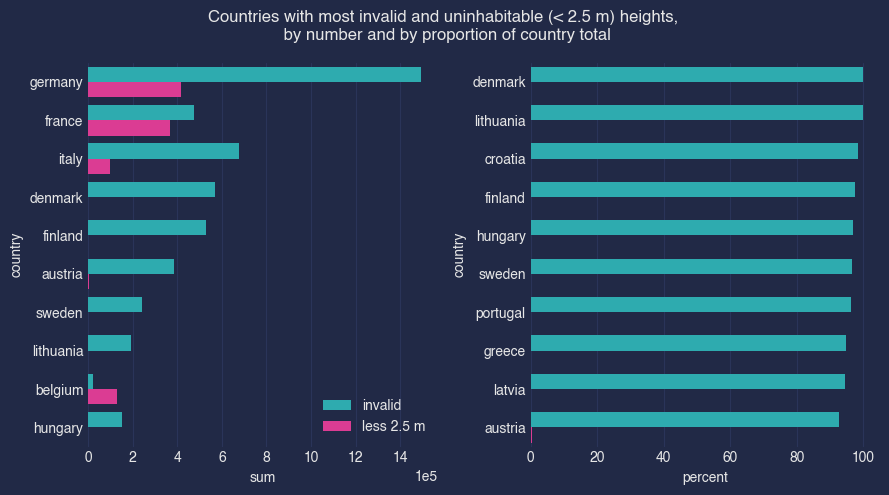

In [14]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=True, figsize=(9,5))
fig.suptitle('''Countries with most invalid and uninhabitable (< 2.5 m) heights, \n by number and by proportion of country total''')


#plot 1 absolute sum
plot_df = dfc_sum.drop(labels=["valid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["sum"].sum().sort_values("sum", ascending=False)
sns.barplot(plot_df, ax=ax1, y="country", hue="cat_height", x="sum", order=orderby["country"][:10]);
ax1.legend(loc='lower right');
# Keep the scientific notation to 1e5
ax1.ticklabel_format(axis="x", style="scientific", scilimits=(5,5)); 

#plot 2 percent ratio
plot_df = dfc_percent.drop(labels=["valid","greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["percent"].sum().sort_values("percent", ascending=False)
sns.barplot(plot_df, ax=ax2, y="country", hue="cat_height", x="percent", order=orderby["country"][:10]);
# remove legend, because it is common with the first plot and  there is no space on the graph
ax2.get_legend().remove()

plt.tight_layout()
plt.show()

Invalid heights (0m or less and null values) are most numerous in Germany and Italy in absolute numbers, but make up almost 100% of entries in Denmark and Lithuania.

Buildings that have erroneously large heights are very rare and not shown. 

The next plot shows just the occurance of heights < 2.5 m, with invalid heights removed.

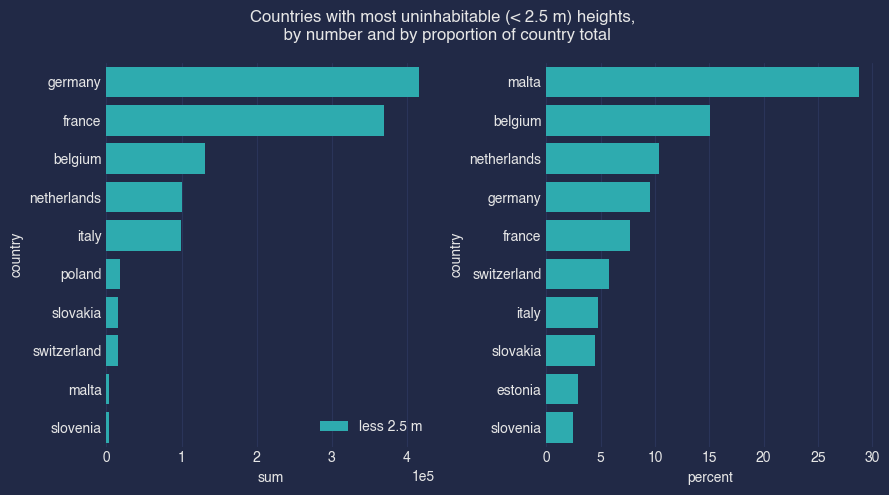

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=True, figsize=(9,5))
fig.suptitle('''Countries with most uninhabitable (< 2.5 m) heights, \n by number and by proportion of country total''')


#plot 1 sum
plot_df = dfc_sum.drop(labels=["valid", "invalid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["sum"].sum().sort_values("sum", ascending=False)
sns.barplot(plot_df, ax=ax1, y="country", hue="cat_height", x="sum", order=orderby["country"][:10]);
ax1.legend(loc='lower right');
# Keep the scientific notation to 1e5
ax1.ticklabel_format(axis="x", style="scientific", scilimits=(5,5)); 

#plot 2 percent
plot_df = dfc_percent.drop(labels=["valid","invalid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["percent"].sum().sort_values("percent", ascending=False)
sns.barplot(plot_df, ax=ax2, y="country", hue="cat_height", x="percent", order=orderby["country"][:10]);
# remove legend, because it is common with the first plot and  there is no space on the graph
ax2.get_legend().remove()

plt.tight_layout()
# sns.despine(left=True, bottom=True)
plt.show()

German, France, Belgium, Netherlands and Italy are in the top 10 countries for most buildings with uninhabitable height, by absolute numbers and by proportion. Let's filter for these countries and display the distribution regionally, to see if there are problem regions. For this we require a mapping to region, for which I have used the EU NUTS system. Centroids are calculated for each EUBUCCO structure and then joined on the region geometry using the "within" predicate. The use of geometries makes the dask routine slower, so I have pared it back a little for efficiency.

https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts


In [16]:
eu_poly = gpd.read_file('NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp').query("LEVL_CODE == 2")

In [17]:
eu_poly

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
104,CZ05,2,CZ,Severovýchod,Severovýchod,0.0,0,0,CZ05,"POLYGON ((15.53527 50.77938, 15.79826 50.74236..."
105,CZ06,2,CZ,Jihovýchod,Jihovýchod,0.0,0,0,CZ06,"POLYGON ((15.49695 49.86118, 16.39363 49.58061..."
106,CZ07,2,CZ,Střední Morava,Střední Morava,0.0,0,0,CZ07,"POLYGON ((18.40360 49.39675, 18.32244 49.31506..."
107,CZ08,2,CZ,Moravskoslezsko,Moravskoslezsko,0.0,0,0,CZ08,"POLYGON ((18.03506 50.06577, 18.32694 49.92850..."
108,DE11,2,DE,Stuttgart,Stuttgart,0.0,0,0,DE11,"POLYGON ((10.08372 49.54356, 10.11833 49.47317..."
...,...,...,...,...,...,...,...,...,...,...
1942,NO08,2,NO,Oslo og Viken,Oslo og Viken,0.0,0,0,NO08,"POLYGON ((8.25170 61.07394, 9.19099 60.79053, ..."
1943,NO09,2,NO,Agder og Sør-Østlandet,Agder og Sør-Østlandet,0.0,0,0,NO09,"POLYGON ((10.32124 59.69125, 10.38076 59.60982..."
1944,NO0A,2,NO,Vestlandet,Vestlandet,0.0,0,0,NO0A,"MULTIPOLYGON (((8.75511 63.42434, 8.88612 63.1..."
1961,NO07,2,NO,Nord-Norge,Nord-Norge,0.0,0,0,NO07,"MULTIPOLYGON (((28.92968 69.05190, 28.81950 69..."


### Regional aggregated: Dask routine with geometry

In [18]:
# For the following operation we require dask geopandas
df = dgp.read_parquet("./data/parquet/", index=False, columns=["height", "geometry"])
df = df.astype(dtype={"height": pd.Float32Dtype()})  
df.geometry = df.centroid
df["cat_height"] = df.height.map(height_cat, meta=pd.Series(dtype=pd.StringDtype()))
df = df.drop("height", axis=1)
df = df.to_crs(epsg=4326)
df = df.sjoin(eu_poly[["geometry", "NUTS_ID"]], predicate='within')
df_sum = df[["NUTS_ID", "cat_height"]].groupby(["NUTS_ID", "cat_height"], sort=True).cat_height.count()


In [19]:
dfc_sum = df_sum.compute()

In [20]:
dfc_sum

NUTS_ID  cat_height
AL03     invalid           8
AT11     invalid       21709
         less 2.5 m        3
         valid           196
AT12     invalid       96872
                       ...  
SK04     less 2.5 m     3420
         valid         80061
TR21     invalid          10
UKN0     invalid         600
         valid             4
Name: cat_height, Length: 654, dtype: int64

In [21]:
dfc_with_CNTR = dfc_sum.rename("count").reset_index().merge(eu_poly[["NUTS_ID", "CNTR_CODE"]],left_on="NUTS_ID", right_on="NUTS_ID")

In [22]:
dfc_with_CNTR.query("CNTR_CODE == 'ES'").groupby("cat_height")["count"].sum()

cat_height
invalid         97298
less 2.5 m          6
valid         1478968
Name: count, dtype: int64

In [23]:
# Percent calculations performed outside the data-heavy dask routine
dfc_sum_NUTS = dfc_sum.groupby(["NUTS_ID"]).sum()
dfc_percent = dfc_sum / dfc_sum_NUTS * 100
dfc_percent = dfc_percent.rename("percent")
dfc_sum = dfc_sum.rename("sum")
dfc_sum_25 = dfc_sum.swaplevel()["less 2.5 m"]
dfc_percent_25 = dfc_percent.swaplevel()["less 2.5 m"]
dfc_sum_all = dfc_sum.swaplevel()
dfc_percent_all = dfc_percent.swaplevel()

In [44]:
## Function for quick plotting of regions as chloropleth 
def plot_map(df, variable, title, vmin=0, vmax=10000):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.style.use('../styles/matplotlib-stylesheets/pitayasmoothie-dark.mplstyle')

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(figsize=(10,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='1%',pad=0.01)
    
    # remove the axis
    ax.axis('off')
    
    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '3'})
    
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(sm, cax=cax, orientation='vertical', shrink=2)


    df.plot(cmap="RdPu",column=variable, linewidth=1, ax=ax, edgecolor='0.8',
                        missing_kwds={'facecolor': 'whitesmoke'}, vmin=vmin, vmax=vmax);
    

    ax.set_xlim(-10,30);
    ax.set_ylim(35, 65);
    plt.show()

### Plotting the regional distribution

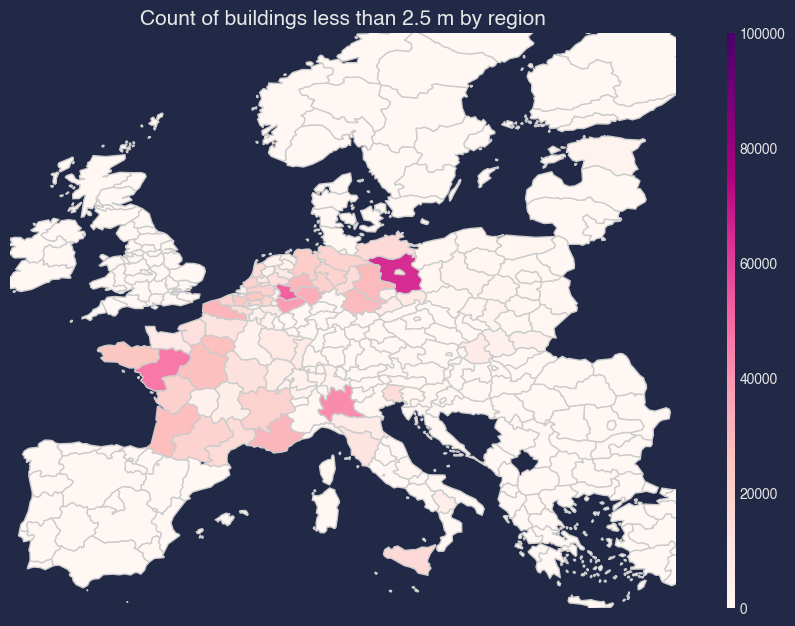

In [43]:
df_plot = eu_poly.merge(dfc_sum_25, how="left", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "sum"]]
df_plot.fillna(0, inplace=True)
plot_map(df_plot, "sum", "Count of buildings less than 2.5 m by region", vmax=100000)

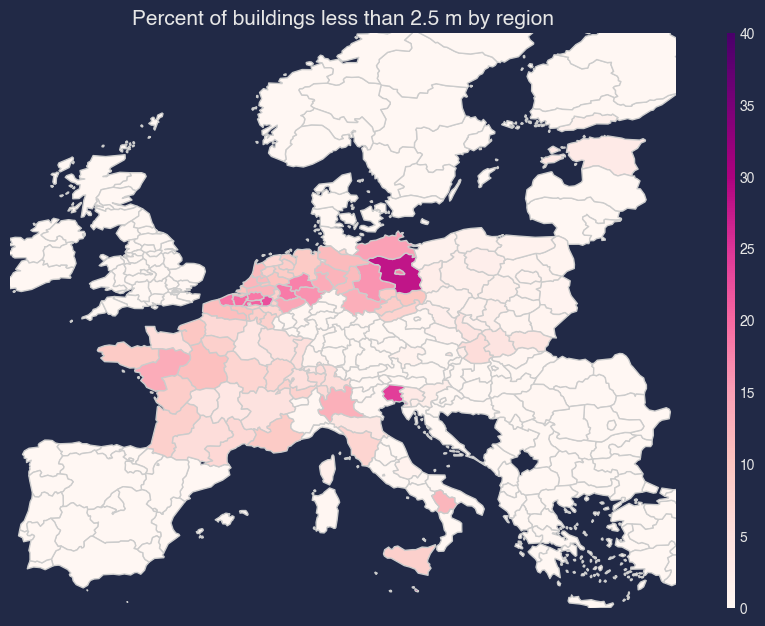

In [45]:
df_plot = eu_poly.merge(dfc_percent_25, how="left", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
df_plot.fillna(0, inplace=True)
plot_map(df_plot, "percent", "Percent of buildings less than 2.5 m by region", vmax=40)

Brandenburg, parts of Belgium and France have the largest proportion of buildings with < 2.5 m height. The following code produces an interactive map of the same data with plotly dash. Cannot be displayed in github directly, so use https://nbviewer.org/.

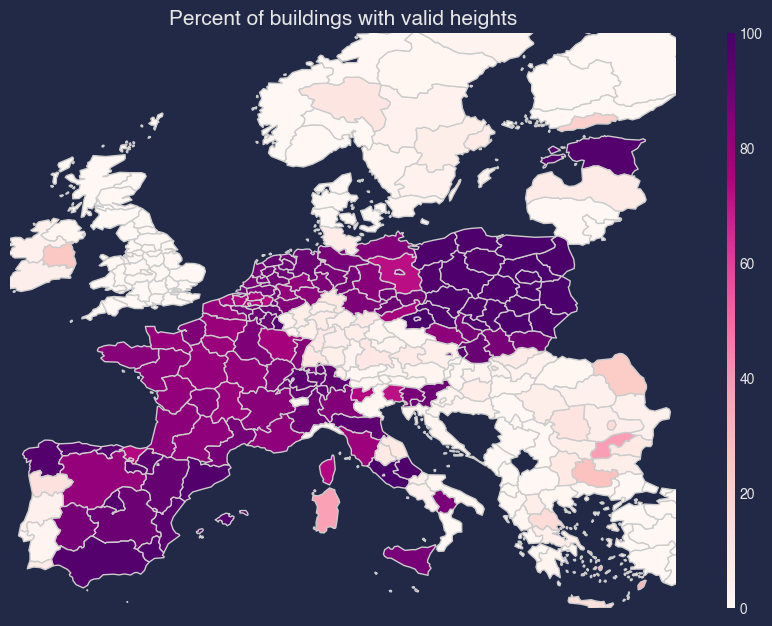

In [46]:
df_plot = eu_poly.merge(dfc_percent_all["valid"], how="left", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
df_plot.fillna(0, inplace=True)
plot_map(df_plot, "percent", "Percent of buildings with valid heights", vmax=100)

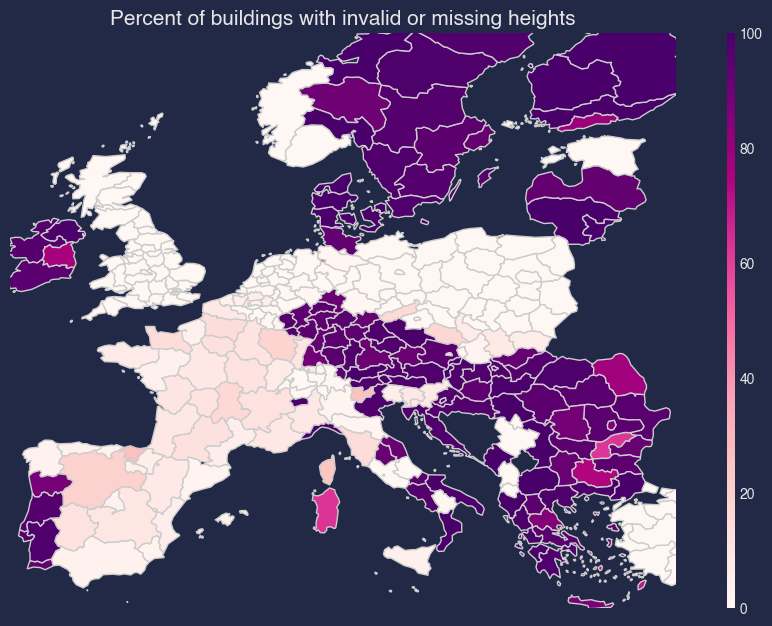

In [49]:
df_plot = eu_poly.merge(dfc_percent_all["invalid"], how="left", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
df_plot.fillna(0, inplace=True)
plot_map(df_plot, "percent", "Percent of buildings with invalid or missing heights", vmax=100)

### Interactive maps are also possible

In [35]:
import plotly.express as px
from shapely import box

df_plot = eu_poly.merge(dfc_percent_25, how="left", left_on="NUTS_ID", 
                        right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
df_plot = df_plot.set_index("NUTS_NAME")
df_plot.fillna(0, inplace=True)
df_plot.percent = df_plot.percent.round(2)

df_plot_filter = df_plot.iloc[df_plot.sindex.query(box(-10, 30, 25, 58))]

fig = px.choropleth(df_plot_filter, geojson=df_plot_filter.geometry, locations=df_plot_filter.index, color='percent',
                           range_color=(0, 30),
                           color_continuous_scale = 'RdPu',
                           projection = "mercator",
                           labels={'percent':'% buildings height < 2.5 m', "NUTS_NAME": "Region"}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)

country
austria          6.803952
belgium         82.329460
bulgaria        14.656631
croatia          1.458836
cyprus          99.876562
czechia         99.638173
estonia         97.113331
finland          2.239106
france          82.429122
germany         56.232800
greece           4.971780
hungary          3.042998
ireland         12.595845
italy           62.472174
latvia           5.576839
luxembourg     100.000000
malta           63.758200
netherlands     89.584493
poland          98.778535
portugal         3.613611
romania          7.097838
slovakia        90.834310
slovenia        90.667043
spain           93.935923
sweden           3.270563
switzerland     94.213132
Name: percent, dtype: float64